In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import copy
import json
from tqdm import tqdm
import pickle
import logging
import math
import matplotlib
# plot calibration of Copilot confidences with XGBoost predictions
from re import S
from scipy.stats.stats import pearsonr  

In [14]:
# open pickle logs_by_user_session_labeled
with open('../data/logs_by_user_session_labeled.pkl', 'rb') as f:
    logs_by_user_session_labeled = pickle.load(f)


In [15]:
all_states = []
all_actions = []
all_times = []
all_suggestions = []
all_states_continuous = []
all_times_continuous = []
all_actions_continuous = []
for i in range(len(logs_by_user_session_labeled)):
    states = logs_by_user_session_labeled[i].LabeledState.to_numpy()
    actions = logs_by_user_session_labeled[i].StateName.to_numpy()
    times = logs_by_user_session_labeled[i].TimeSpentInState.to_numpy()
    suggestions = logs_by_user_session_labeled[i].CurrentSuggestion.to_numpy()
    # clean up states
    for j in range(len(states)):
        if states[j] == 'IDK':
            states[j] = 'IDK (I)'
        if states[j] == 'Looking up documentation' or states[j] == 'Looking up documentation (N)':
            states[j] = 'Looking up Documentation (N)'
        if states[j] == 'h':
            states[j] = 'Thinking About New Code To Write (F)'
        if states[j] == 'Thinking about new code to write (F)':
            states[j] = 'Thinking About New Code To Write (F)'

    # get indices where state is IDK
    idk_indices = [i for i in range(len(states)) if states[i] == 'IDK (I)']
    states = [states[i] for i in range(len(states)) if i not in idk_indices]
    actions = [actions[i] for i in range(len(actions)) if i not in idk_indices]
    times = [times[i] for i in range(len(times)) if i not in idk_indices]

    states_continuous = []
    times_continuous = []
    actions_continuous = []
    # merge states with same name
    last_state = ""
    times_cumalitive = 0
    for i in range(len(states)):
        if states[i] != last_state:
            states_continuous.append(states[i])
            last_state = states[i]
            times_continuous.append(times_cumalitive + times[i])
            times_cumalitive = 0
        else:
            times_cumalitive += times[i]
    all_states_continuous.extend(states_continuous)
    all_times_continuous.extend(times_continuous)
    all_states.append(states)
    all_actions.append(actions)
    all_times.append(times)
    all_suggestions.append(suggestions)

In [16]:
# merge all pandas dataframes of logs_by_user_session_labeled into a single dataframe
all_users_df = pd.concat(logs_by_user_session_labeled)
all_users_df.reset_index(drop=True, inplace=True)

# Time Adjustments

In [17]:
# for defer thought, check time after
defer_thought_original = []
defer_thought_new = []
post_thinking_time = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if  all_states[j][i] == 'Deferring Thought For Later (D)':
            defer_thought_original.append(all_times[j][i])
            if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                defer_thought_new.append(all_times[j][i+1]+ all_times[j][i])
                post_thinking_time.append(all_times[j][i+1])
            else:
                defer_thought_new.append(all_times[j][i])
# mean of original and new

print(f'Defer Thought should add the thinking veriyfing suggestion time after the action n = {len(defer_thought_new)}')
print(f' (means) before adjusting: {np.mean(defer_thought_original):.2f} +- {np.std(defer_thought_original):.2f} after adjusting: {np.mean(defer_thought_new):.2f} +- {np.std(defer_thought_new):.2f}')
print(f' (median) before adjusting: {np.median(defer_thought_original):.2f} +- {np.std(defer_thought_original):.2f} after adjusting: {np.median(defer_thought_new):.2f} +- {np.std(defer_thought_new):.2f}')
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html
print(f' post thinking time (means) {np.mean(post_thinking_time):.2f} +- {np.std(post_thinking_time):.2f} occurs {len(post_thinking_time)/len(defer_thought_new)}')
# paired t-test
import scipy
def paired_ttest(a, b):
    return scipy.stats.ttest_rel(a, b)
print(paired_ttest(defer_thought_original, defer_thought_new))

Defer Thought should add the thinking veriyfing suggestion time after the action n = 86
 (means) before adjusting: 2.41 +- 3.15 after adjusting: 11.03 +- 18.80
 (median) before adjusting: 1.31 +- 3.15 after adjusting: 3.10 +- 18.80
 post thinking time (means) 22.46 +- 21.23 occurs 0.38372093023255816
Ttest_relResult(statistic=-4.649000252559726, pvalue=1.210616066807125e-05)


Difference in mean: -8.62
Difference in median: -1.80
p value: 4.867047805462982e-05


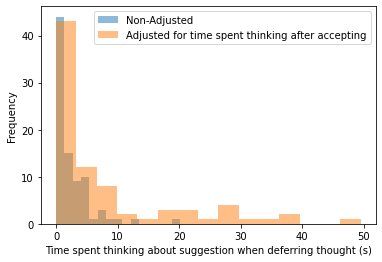

In [18]:
# test if there is a difference in the mean
print(f'Difference in mean: {np.mean(defer_thought_original) - np.mean(defer_thought_new):.2f}')
print(f'Difference in median: {np.median(defer_thought_original) - np.median(defer_thought_new):.2f}')
# two sample t test if significant
from scipy.stats import ttest_ind
print(f'p value: {ttest_ind(defer_thought_original, defer_thought_new)[1]}')
# plot
# truncate times to only show first 10 seconds
defer_thought_original_trunc = [i for i in defer_thought_original if i < 50]
defer_thought_new_trunc = [i for i in defer_thought_new if i < 50]

plt.hist(defer_thought_original_trunc, bins=15, alpha=0.5, label='Non-Adjusted')
plt.hist(defer_thought_new_trunc, bins=15, alpha=0.5, label='Adjusted for time spent thinking after accepting')
plt.legend()
plt.xlabel('Time spent thinking about suggestion when deferring thought (s)')
plt.ylabel('Frequency')
plt.savefig('defer_thought_hist.pdf')
plt.show()


In [19]:
# for thinking , check time after
thinking_original = []
thinking_new = []
post_thinking_time = []

for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if  all_states[j][i] == 'Thinking/Verifying Suggestion (A)':
            thinking_original.append(all_times[j][i])
            new_time = all_times[j][i]
            if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                new_time += all_times[j][i+1]
                post_thinking_time.append(all_times[j][i+1])

            #if all_states[j][i-1] == 'Waiting For Suggestion (G)':
            #    new_time += all_times[j][i-1]
            thinking_new.append(new_time)
# mean of original and new

# print
print(f' post thinking time (means) {np.mean(post_thinking_time):.2f} +- {np.std(post_thinking_time):.2f} occurs {len(post_thinking_time)/len(thinking_new)}')

print(f'Thinking should add  and time spent thinking after   n={len(thinking_new)} ')
print(f'(means) before adjusting: {np.mean(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.mean(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(f' (median) before adjusting: {np.median(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.median(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(paired_ttest(thinking_original, thinking_new))

 post thinking time (means) 5.51 +- 12.76 occurs 0.5127388535031847
Thinking should add  and time spent thinking after   n=628 
(means) before adjusting: 5.27 +- 11.89 after adjusting: 8.09 +- 16.63
 (median) before adjusting: 1.21 +- 11.89 after adjusting: 2.38 +- 16.63
Ttest_relResult(statistic=-7.410473984278942, pvalue=4.0880382584636513e-13)


In [20]:
# t test if significant
print(f'p value: {ttest_ind(thinking_original, defer_thought_original)}')

p value: Ttest_indResult(statistic=2.2178511765774935, pvalue=0.026879855723199054)


In [21]:
# for defer thought, check time after
thinking_original = []
thinking_new = []
waiting_time = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted', 'Rejected'] and all_states[j][i] in ['Thinking/Verifying Suggestion (A)',
                'Waiting For Suggestion (G)', 'Deferring Thought For Later (D)', 'Thinking About New Code To Write (F)']:
            thinking_original.append(all_times[j][i])
            new_time = all_times[j][i]
            if all_states[j][i-1] == 'Waiting For Suggestion (G)':
                waiting_time.append(all_times[j][i-1])
                new_time += all_times[j][i-1]
            thinking_new.append(new_time)
# mean of original and new

# print
print(f'Thinking should add  the time spent waiting before  n={len(thinking_new)} ')
print(f'(means) before adjusting: {np.mean(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.mean(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(f' (median) before adjusting: {np.median(thinking_original):.2f} +- {np.std(thinking_original):.2f} after adjusting: {np.median(thinking_new):.2f} +- {np.std(thinking_new):.2f}')
print(paired_ttest(thinking_original, thinking_new))
print(f' waiting time {np.mean(waiting_time):.2f} +- {np.std(waiting_time):.2f} and probability {len(waiting_time)/len(thinking_new)}')

Thinking should add  the time spent waiting before  n=439 
(means) before adjusting: 6.11 +- 15.52 after adjusting: 6.51 +- 15.61
 (median) before adjusting: 1.99 +- 15.52 after adjusting: 2.19 +- 15.61
Ttest_relResult(statistic=-5.508651375506937, pvalue=6.177425718343933e-08)
 waiting time 2.55 +- 3.08 and probability 0.15945330296127563


# Analysis of suggestions that are defered thought vs not

In [22]:
# get suggestions in all_users_df where LabeledState is Defered Thought
defered_thought_suggestions = all_users_df[all_users_df['LabeledState'] == 'Deferring Thought For Later (D)'].CurrentSuggestion.to_numpy()
thinking_suggestions = all_users_df[all_users_df['LabeledState'] == 'Thinking/Verifying Suggestion (A)'].CurrentSuggestion.to_numpy()
# print random sample of suggestions from each 
print('defered_thought_suggestions \n \n')
print(defered_thought_suggestions[np.random.randint(len(defered_thought_suggestions), size=10)])
print('thinking suggestions \n \n')
print(thinking_suggestions[np.random.randint(len(thinking_suggestions), size=10)])

# compare number of characters and lines between the two groups
defered_thought_suggestions_characters = []
thinking_suggestions_characters = []
defered_thought_suggestions_lines = []
thinking_suggestions_lines = []
for i in range(len(defered_thought_suggestions)):
    defered_thought_suggestions_characters.append(len(defered_thought_suggestions[i]))
    defered_thought_suggestions_lines.append(len(defered_thought_suggestions[i].split('\\n')))

for i in range(len(thinking_suggestions)):
    thinking_suggestions_characters.append(len(thinking_suggestions[i]))
    thinking_suggestions_lines.append(len(thinking_suggestions[i].split('\\n')))

# print average and median number of characters and lines for each group
print(f'n = {len(defered_thought_suggestions)}Avg characters for defered thought suggestions: {np.mean(defered_thought_suggestions_characters):.2f} median characters: {np.median(defered_thought_suggestions_characters):.2f} std characters: {np.std(defered_thought_suggestions_characters):.2f}')
print(f'Avg lines for defered thought suggestions: {np.mean(defered_thought_suggestions_lines):.2f} median lines: {np.median(defered_thought_suggestions_lines):.2f} std lines: {np.std(defered_thought_suggestions_lines):.2f}')
print(f'n = {len(thinking_suggestions_characters)}Avg characters for thinking suggestions: {np.mean(thinking_suggestions_characters):.2f} median characters: {np.median(thinking_suggestions_characters):.2f} std characters: {np.std(thinking_suggestions_characters):.2f}')
print(f'Avg lines for thinking suggestions: {np.mean(thinking_suggestions_lines):.2f} median lines: {np.median(thinking_suggestions_lines):.2f} std lines: {np.std(thinking_suggestions_lines):.2f}')
# two sample t test, one for characters and one for lines
from scipy.stats import ttest_ind
print(f'ttest_ind(thinking_suggestions_characters, defered_thought_suggestions_characters) = {ttest_ind(thinking_suggestions_characters, defered_thought_suggestions_characters)}')
print(f'ttest_ind(thinking_suggestions_lines, defered_thought_suggestions_lines) = {ttest_ind(thinking_suggestions_lines, defered_thought_suggestions_lines)}')



defered_thought_suggestions 
 

['"    for j in range(len(row)):"' '"    def get_text(self):"'
 '"    def add_text(self, text):"' '"    def add_id(self, id):"'
 '"randomforest.fit(X_train, Y_train)"'
 '"i, v) in enumerate(query):\\n            if i % 2 == 0:\\n                query[i] = v ** 2\\n            else:\\n                query[i] = abs(v)"'
 '"# add a method to the class called \\"get_text\\" that returns the \\"text\\" attribute"'
 '"    combinations = np.multiply.outer(row, row)"'
 '"features(x, y, k):\\n    # pick k features that are most correlated with y\\n    # x is a numpy array of shape (n, m)\\n    # y is a numpy array of shape (n,)\\n    # return a numpy array of shape (n, k)\\n    corr = np.corrcoef(x, y, rowvar=False)\\n    corr = corr[-1, :-1]\\n    idx = np.argsort(corr)\\n    idx = idx[-k:]\\n    return x[:, idx]"'
 '"i, v) in enumerate(query):\\n            if i % 2 == 0:\\n                query[i] = v ** 2\\n            else:\\n                query[i] = abs(

In [23]:
prev_states_defer = {}
prev_states_thinking = {}
for j in range(1, len(all_states)):
    for i in range(len(all_states[j])):
        if all_states[j][i] == 'Deferring Thought For Later (D)':
            if all_states[j][i-1] not in prev_states_defer:
                prev_states_defer[all_states[j][i-1]] = 1
            else:
                prev_states_defer[all_states[j][i-1]] += 1
        if all_states[j][i] == 'Thinking/Verifying Suggestion (A)':
            if all_states[j][i-1] not in prev_states_thinking:
                prev_states_thinking[all_states[j][i-1]] = 1
            else:
                prev_states_thinking[all_states[j][i-1]] += 1

# instead of counts make it a probability
sum_defer = sum(prev_states_defer.values())
for key in prev_states_defer:
    prev_states_defer[key] = prev_states_defer[key]/sum_defer
sum_thinking = sum(prev_states_thinking.values())
for key in prev_states_thinking:
    prev_states_thinking[key] = prev_states_thinking[key]/sum_thinking
    
# print
print(f'prev_states_defer = {prev_states_defer}')
print(f'prev_states_thinking = {prev_states_thinking}')


prev_states_defer = {'Thinking/Verifying Suggestion (A)': 0.12790697674418605, 'Writing New Functionality (Z)': 0.20930232558139536, 'Deferring Thought For Later (D)': 0.29069767441860467, 'Thinking About New Code To Write (F)': 0.06976744186046512, 'Edditing Last Suggestion (X)': 0.046511627906976744, 'Waiting For Suggestion (G)': 0.13953488372093023, 'Debugging/Testing Code (H)': 0.023255813953488372, 'Editing Written Code(C)': 0.011627906976744186, 'Prompt Crafting (V)': 0.06976744186046512, 'Looking up Documentation (N)': 0.011627906976744186}
prev_states_thinking = {'Waiting For Suggestion (G)': 0.08376068376068375, 'Edditing Last Suggestion (X)': 0.03076923076923077, 'Prompt Crafting (V)': 0.0905982905982906, 'Thinking/Verifying Suggestion (A)': 0.5008547008547009, 'Writing New Functionality (Z)': 0.15897435897435896, 'Thinking About New Code To Write (F)': 0.046153846153846156, 'Debugging/Testing Code (H)': 0.015384615384615385, 'Deferring Thought For Later (D)': 0.0564102564102

# likelihood of editing depending on thinking time

In [24]:
counts_edits = {'Deferring Thought For Later (D)':0, 'Thinking/Verifying Suggestion (A)':0, 'Waiting For Suggestion (G)':0, 'Thinking About New Code To Write (F)':0}
counts_states = {'Deferring Thought For Later (D)':0, 'Thinking/Verifying Suggestion (A)':0, 'Waiting For Suggestion (G)':0, 'Thinking About New Code To Write (F)':0}

for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted']:
            if all_states[j][i] == 'Thinking/Verifying Suggestion (A)':
                counts_states['Thinking/Verifying Suggestion (A)'] += 1
                if all_states[j][i+1] == 'Editing Last Suggestion (X)':
                    counts_edits['Thinking/Verifying Suggestion (A)'] += 1
            if all_states[j][i] == 'Deferring Thought For Later (D)':
                counts_states['Deferring Thought For Later (D)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Deferring Thought For Later (D)'] += 1
            if all_states[j][i] == 'Waiting For Suggestion (G)':
                counts_states['Waiting For Suggestion (G)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Waiting For Suggestion (G)'] += 1
            if all_states[j][i] == 'Thinking About New Code To Write (F)':
                counts_states['Thinking About New Code To Write (F)'] += 1
                if all_states[j][i+1] == 'Thinking/Verifying Suggestion (A)':
                    counts_edits['Thinking About New Code To Write (F)'] += 1
# print probability of edit
print(counts_edits)
print(counts_states)
print(f'Probability of edit Thinking/Verifying Suggestion (A):  {counts_edits["Thinking/Verifying Suggestion (A)"]/counts_states["Thinking/Verifying Suggestion (A)"]}')
print(f'Probability of edit Deferring Thought For Late: {counts_edits["Deferring Thought For Later (D)"]/counts_states["Deferring Thought For Later (D)"]}')
print(f'Probability of edit Thinking About New Code To Write: {counts_edits["Thinking About New Code To Write (F)"]/counts_states["Thinking About New Code To Write (F)"]}')

{'Deferring Thought For Later (D)': 33, 'Thinking/Verifying Suggestion (A)': 39, 'Waiting For Suggestion (G)': 0, 'Thinking About New Code To Write (F)': 2}
{'Deferring Thought For Later (D)': 62, 'Thinking/Verifying Suggestion (A)': 216, 'Waiting For Suggestion (G)': 3, 'Thinking About New Code To Write (F)': 8}
Probability of edit Thinking/Verifying Suggestion (A):  0.18055555555555555
Probability of edit Deferring Thought For Late: 0.532258064516129
Probability of edit Thinking About New Code To Write: 0.25


In [25]:
from scipy.stats import ttest_ind
thinking_accepts = [0] * counts_states['Thinking/Verifying Suggestion (A)']
thinking_accepts[0:counts_edits['Thinking/Verifying Suggestion (A)']] = [1] * counts_edits['Thinking/Verifying Suggestion (A)']
writing_accepts = [0] * counts_states['Deferring Thought For Later (D)']
writing_accepts[0:counts_edits['Deferring Thought For Later (D)']] = [1] * counts_edits['Deferring Thought For Later (D)']
# shuffle both arrays
np.random.shuffle(thinking_accepts)
np.random.shuffle(writing_accepts)


# chi square test to compare means
from scipy.stats import chi2_contingency
table = [[counts_edits['Thinking/Verifying Suggestion (A)'], counts_states['Thinking/Verifying Suggestion (A)'] - counts_edits['Thinking/Verifying Suggestion (A)']], [counts_edits['Deferring Thought For Later (D)'], counts_states['Deferring Thought For Later (D)'] - counts_edits['Deferring Thought For Later (D)']]]

stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

stat=29.243, p=0.000
Different proportions of accepts (reject H0)


Linear regression: slope=3.34, intercept=0.37, r_value=0.56, p_value=0.00, std_err=0.71
Pearson correlation: correlation=0.56, p_value=0.00


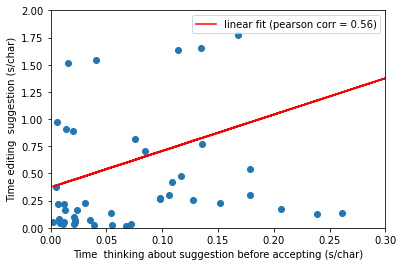

In [26]:
time_thinking_list = []
time_editing_list = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted']:
            if all_states[j][i+1] == 'Editing Last Suggestion (X)':
                word_lenght = len(all_suggestions[j][i])
                time_editing_list.append(all_times[j][i+1]/word_lenght)
                time_thinking_list.append(all_times[j][i]/word_lenght)

# plot the two lists against each other and see if correlations
plt.scatter( time_thinking_list, time_editing_list)
plt.ylabel('Time editing  suggestion (s/char)')
plt.xlabel('Time  thinking about suggestion before accepting (s/char)')
# make x and y axis same

# linear trend
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress( time_thinking_list, time_editing_list)
print(f'Linear regression: slope={slope:.2f}, intercept={intercept:.2f}, r_value={r_value:.2f}, p_value={p_value:.2f}, std_err={std_err:.2f}')
# get correlation between time thinking and time editing
from scipy.stats import pearsonr
correlation, p_value = pearsonr( time_thinking_list, time_editing_list)
print(f'Pearson correlation: correlation={correlation:.2f}, p_value={p_value:.2f}')
plt.plot(time_thinking_list, [slope*x+intercept for x in time_thinking_list], 'r', label=f'linear fit (pearson corr = {correlation:.2f})')
plt.xlim(0,0.3)
plt.ylim(0,2)
plt.legend()
plt.savefig('time_editing_time_thinking.pdf')
plt.show()

/tmp/ipykernel_9699/441535929.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'thinking', color='orange')
/tmp/ipykernel_9699/441535929.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'editing', color='blue')
/tmp/ipykernel_9699/441535929.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'sum', color='green')


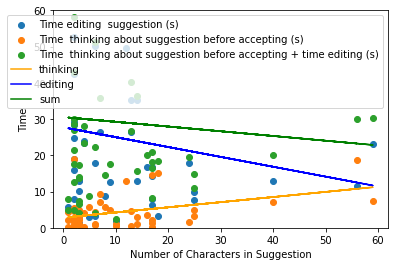

In [27]:
time_thinking_list = []
time_editing_list = []
suggs_lenght = []
sum_time_edit = []
for j in range(len(all_states)):
    for i in range(len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted']:
            if all_states[j][i+1] == 'Editing Last Suggestion (X)':
                word_lenght = len(all_suggestions[j][i].split())
                time_editing_list.append(all_times[j][i+1])
                time_thinking_list.append(all_times[j][i])
                suggs_lenght.append(word_lenght)
                sum_time_edit.append((all_times[j][i+1]+all_times[j][i]))

# plot the two lists against each other and see if correlations
plt.scatter( suggs_lenght, time_editing_list, label='Time editing  suggestion (s)')
plt.scatter(    suggs_lenght, time_thinking_list, label='Time  thinking about suggestion before accepting (s)')
plt.scatter(    suggs_lenght, sum_time_edit, label='Time  thinking about suggestion before accepting + time editing (s)')
plt.ylabel('Time')
plt.xlabel('Number of Characters in Suggestion')
# make x and y axis same
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress( suggs_lenght, time_thinking_list)
# get correlation between time thinking and time editing
plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'thinking', color='orange')

slope, intercept, r_value, p_value, std_err = linregress( suggs_lenght, time_editing_list)
# get correlation between time thinking and time editing
plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'editing', color='blue')

slope, intercept, r_value, p_value, std_err = linregress( suggs_lenght, sum_time_edit)
# get correlation between time thinking and time editing
plt.plot(suggs_lenght, [slope*x+intercept for x in suggs_lenght], 'r', label=f'sum', color='green')


#plt.xlim(0,0.3)
plt.ylim(0,60)
plt.legend()
plt.show()

# Prompt Crafting Understanding

In [28]:
# probability of accept while prompt crafting
prompt_crafting_count = 0
accepted_when_prompt_crafting = 0
for j in range(len(all_states)):
    for i in range(1, len(all_states[j])-1):
        if all_actions[j][i] in ['Accepted', 'Rejected']:
            if all_states[j][i] == 'Prompt Crafting (V)':
                prompt_crafting_count += 1
                if all_actions[j][i] == 'Accepted':# and all_states[j][i+1] == 'Prompt Crafting (V)':
                        accepted_when_prompt_crafting += 1

print(f'n = {prompt_crafting_count} Probability of accept while prompt crafting: {accepted_when_prompt_crafting/prompt_crafting_count}')

n = 234 Probability of accept while prompt crafting: 0.10683760683760683


In [29]:
# how often does prompt crafting end in an accept
# probability of accept while prompt crafting
prompt_crafting_count = 0
accepted_when_prompt_crafting = 0
for j in range(len(all_states)):
    i = 0
    while i < len(all_states[j])-1:
        if all_states[j][i] == 'Prompt Crafting (V)':
            # get state where prompt crafting ends
            last_prompt_state = i
            prompt_crafting_count += 1
            last_episode_state = i
            for k in range(i+1, len(all_states[j])):
                if all_states[j][k] in [ 'Writing New Functionality (Z)', 'Editing Written Code(C)']:
                    # this means prompt crafting ended, let's check if there was an accept just before prompt crafting ended
                    last_episode_state = k
                    break

            for k in range(i+1, last_episode_state):
                if all_states[j][k] == 'Prompt Crafting (V)':
                    last_prompt_state = k
                    

            for k in range(last_prompt_state+1, last_episode_state):
                if all_actions[j][k] == 'Accepted':
                    accepted_when_prompt_crafting += 1
                    break
            
            i = last_episode_state + 1
            # print the trajectory
        else:
            i += 1

print(f'n = {prompt_crafting_count} Probability of accept after prompt crafting: {accepted_when_prompt_crafting/prompt_crafting_count}')

n = 284 Probability of accept after prompt crafting: 0.07394366197183098


# Predicting Actions from Hidden States

In [30]:
# given each state get probability of accept
states_accept = {}
states_count = {}

for j in range(len(all_states)):
    for i in range(1, len(all_states[j])):
        if all_actions[j][i] in ['Accepted', 'Rejected']:
            state_now = all_states[j][i]
            state_before = all_states[j][i-1]
            if state_now not in states_count:
                states_count[state_now] = 1
                states_accept[state_now] = 0

            else:
                states_count[state_now] += 1

            if state_before not in states_count:
                states_accept[state_before] = 0
                states_count[state_before] = 1
            else:  
                states_count[state_before] += 1
            
            if all_actions[j][i] == 'Accepted':
                states_accept[state_now] += 1
                states_accept[state_before] += 1

print(f'Probability of accept for each state:')
for state in states_count:
    print(f'{state}: {states_accept[state]/states_count[state]}')
    

Probability of accept for each state:
Thinking/Verifying Suggestion (A): 0.702819956616052
Prompt Crafting (V): 0.16382978723404254
Looking up Documentation (N): 0.25
Writing New Functionality (Z): 0.1989100817438692
Thinking About New Code To Write (F): 0.2073170731707317
Edditing Last Suggestion (X): 0.16037735849056603
Waiting For Suggestion (G): 0.4188034188034188
Editing Written Code(C): 0.11428571428571428
Writing Documentation (B): 0.36363636363636365
Debugging/Testing Code (H): 0.25555555555555554
Deferring Thought For Later (D): 0.9879518072289156
Not Thinking (S): 1.0


In [31]:
from scipy.stats import ttest_ind
thinking_accepts = [0] * states_count['Thinking/Verifying Suggestion (A)']
thinking_accepts[0:states_accept['Thinking/Verifying Suggestion (A)']] = [1] * states_accept['Thinking/Verifying Suggestion (A)']
writing_accepts = [0] * states_count['Thinking About New Code To Write (F)']
writing_accepts[0:states_accept['Thinking About New Code To Write (F)']] = [1] * states_accept['Thinking About New Code To Write (F)']
# shuffle both arrays
np.random.shuffle(thinking_accepts)
np.random.shuffle(writing_accepts)


# chi square test to compare means
from scipy.stats import chi2_contingency
table = [[states_accept['Thinking/Verifying Suggestion (A)'], states_count['Thinking/Verifying Suggestion (A)'] - states_accept['Thinking/Verifying Suggestion (A)']], [states_accept['Thinking About New Code To Write (F)'], states_count['Thinking About New Code To Write (F)'] - states_accept['Thinking About New Code To Write (F)']]]
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpret p-value
alpha = 0.05
if p > alpha:
    print('Same proportions of accepts (fail to reject H0)')
else:
    print('Different proportions of accepts (reject H0)')
    

stat=119.357, p=0.000
Different proportions of accepts (reject H0)
